## chernobyl_balances_radiation.ipynb (qiime2)

In this study, there were 137 vole fecal samples collected from Chernobyl and Ukraine. Each of these fecal samples had a radiation measurement. From this [manuscript](), it was observed that radiation (loc_rad_geiger_gamma_usv_per_h) plays a primary role in community composition (e.g., the ratio of Firmicutes/Bacteroidetes). Here, we will show that radiation by itself can actually predict the microbial abundances, using balance trees.

Before beginning this analysis, make sure that the following is installed

```
conda create -n qiime2-2017.7 --file https://data.qiime2.org/distro/core/qiime2-2017.7-conda-osx-64.txt

source activate qiime2-2017.7

conda uninstall gneiss

pip install git+https://github.com/mortonjt/pls-balances

pip install git+https://github.com/mortonjt/gneiss.git@proportion_plots
```

In [35]:
import pandas as pd
from statsmodels.sandbox.stats.multicomp import multipletests
from skbio import TreeNode
import seaborn as sns
import matplotlib.pyplot as plt
from gneiss.plot import balance_boxplot, balance_barplots, proportion_plot
from pls_balances.src.balances import balance_classify, round_balance
import qiime2
import numpy as np
import matplotlib
%matplotlib inline
np.random.seed(0)
#font = {'family' : 'norma
#        'size'   : 16}

#matplotlib.rc('font', **font)

In [36]:
table_file = '../potato/data/openms_noise5k/ft-w-gnpsid-norm-hdf5.biom.qza'
metadata_file = '../potato/data/potato_untargeted_metabolomics_metadata.txt'

# taxa_file = 'voles_137_sortmerna_taxonomy.txt'
# taxa = pd.read_table(taxa_file, index_col=0)

table = qiime2.Artifact.load(table_file).view(pd.DataFrame)
metadata = pd.read_table(metadata_file, index_col=0)

# Classification

In [37]:
from gneiss.util import match
table, metadata = match(table, metadata)

Set them colors

In [38]:
palette = sns.color_palette()

In [39]:
def rgb2hex(r, g, b):
    return '#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255))

In [40]:
ch_color = '#%02x%02x%02x' % (227, 26, 28)
cl_kl_color = '#%02x%02x%02x' % (166, 206, 227)

kl_color = '#%02x%02x%02x' % (51, 160, 44)
cl_color = '#%02x%02x%02x' % (31, 120, 180)

In [41]:
metadata.head(5)

,BarcodeSequence,Description,LinkerPrimerSequence,cultivar_type,cultivar_color,processing_type,network_group,order
#SampleID,,,,,,,,
RWA3,Not applicable,Plant Tissue Metabolome,Not applicable,Atlantic,White,Raw,group1,1
FWA2,Not applicable,Plant Tissue Metabolome,Not applicable,Atlantic,White,French Fries,group1,5
FRM3,Not applicable,Plant Tissue Metabolome,Not applicable,Mountain Rose,Red,French Fries,group2,5
BRR3,Not applicable,Plant Tissue Metabolome,Not applicable,All Red,Red,Baked,group2,4
RWB2,Not applicable,Plant Tissue Metabolome,Not applicable,Russet Burbank,White,Raw,group1,1


# comapring potato colors (purple vs. red+white)

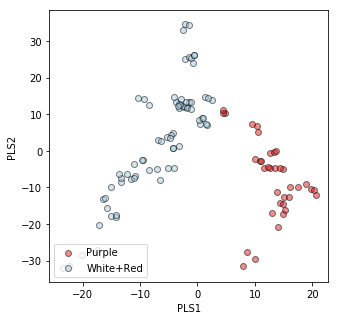

In [42]:
from sklearn.cross_decomposition import PLSRegression
from skbio.stats.composition import clr, centralize

fig, ax = plt.subplots(figsize=(5, 5))


c1 = (metadata.cultivar_color == 'Purple').values
c2 = np.logical_or((metadata.cultivar_color == 'White').values,
                   (metadata.cultivar_color == 'Red').values)
Y = np.vstack((c1, c2)).astype(np.int).T
rad_pls = PLSRegression(n_components=2)
ctable = pd.DataFrame(clr(centralize(table+1)), 
                      index=table.index, columns=table.columns)
rad_pls.fit(X=ctable.values, Y=Y)

ax.scatter(rad_pls.x_scores_[c1, 0], rad_pls.x_scores_[c1, 1], 
           color=ch_color, label='Purple', edgecolor='k', marker='o', alpha=0.5)
ax.scatter(rad_pls.x_scores_[c2, 0], rad_pls.x_scores_[c2, 1], 
           color=cl_kl_color, label='White+Red', edgecolor='k', marker='o', alpha=0.5)
ax.set_xlabel('PLS1')
ax.set_ylabel('PLS2')
ax.legend(loc=3)

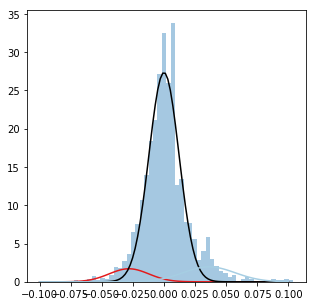

In [43]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import numpy as np

fig, ax = plt.subplots(figsize=(5, 5))
rad_pls = PLSRegression(n_components=1)
rad_pls.fit(X=ctable.values, Y=Y)

rad_spectrum = pd.DataFrame(rad_pls.x_weights_, index=ctable.columns, columns=['PLS1'])

rad_mixture = GaussianMixture(n_components=3, 
                              means_init=np.array([[-0.05], [0], [0.05]]), 
                              random_state=0)
rad_mixture.fit(X=rad_spectrum.values)

rad_m = np.ravel(rad_mixture.means_)
rad_s = np.ravel(np.sqrt(rad_mixture.covariances_)) 
rad_w = np.ravel(rad_mixture.weights_)

x = np.linspace(-0.1, 0.1, 100)
sns.distplot(rad_spectrum, norm_hist=True, kde=False, ax=ax)
ax.plot(x, rad_w[0]*norm.pdf(x, rad_m[0], rad_s[0]), ch_color)
ax.plot(x, rad_w[1]*norm.pdf(x, rad_m[1], rad_s[1]), '-k')
ax.plot(x, rad_w[2]*norm.pdf(x, rad_m[2], rad_s[2]), cl_kl_color)

In [44]:
l, r = round_balance(rad_spectrum, means_init=np.array([[-0.05], [0], [0.05]]))

denom = rad_spectrum.loc[rad_spectrum.PLS1 < l]
num = rad_spectrum.loc[rad_spectrum.PLS1 > r]

r, s = num.shape[0], denom.shape[0] 
rad_balance = (np.log(table.loc[:, num.index] + 1).mean(axis=1) - 
               np.log(table.loc[:, denom.index] + 1).mean(axis=1)) * np.sqrt(r*s / (r+s))

In [45]:
num.shape

(234, 1)

In [46]:
denom.shape

(112, 1)

In [47]:
num.sort_values(by='PLS1', ascending=False)

,PLS1
951.2860_296.8252,0.103875
949.2672_284.7604,0.100513
965.2932_307.6715,0.100163
641.1832_296.5703,0.097341
968.3182_299.8724,0.097067
Anthocyanin [M+]|Coumaroylated Anthocyanidin Gloucoside|3-(Coum-Rha-Glc)-5-Glc-Petunidin_r26,0.094325
1408.9012_293.6783,0.093677
963.3027_303.5607,0.092212
1408.3994_293.4014,0.091580
919.2590_290.2628,0.089602


In [48]:
denom.sort_values(by='PLS1')

,PLS1
695.3653_294.0873,-0.072336
579.1825_275.8646,-0.069676
1059.4608_382.5322,-0.062642
103.0546_ 70.0223,-0.062031
166.5085_ 69.9654,-0.061169
1059.2015_380.8330,-0.058352
1058.9507_380.8708,-0.058280
887.2637_311.3506,-0.058255
1058.6991_380.8330,-0.058081
1073.4560_375.4202,-0.057965


In [49]:
cats = pd.Series(c1, index=metadata.index)

In [78]:
res = balance_classify(table, cats, num_folds=4, 
                       means_init=np.array([[-0.05], [0], [0.05]]) )
num, denom, rad_balance, cv = res
cv

,Q2,AUROC
0,-85.3958,1
1,-57.2326,1
2,-139.243,0.971429
3,-87.3947,0.976471


In [79]:
cv['AUROC'].mean()

0.98697478991596643

In [80]:
num = num.sort_values(by='PLS1', ascending=False)
denom = denom.sort_values(by='PLS1', ascending=True)

In [81]:
num.head()

,PLS1
Anthocyanin [M+]|Coumaroylated Anthocyanidin Gloucoside|3-(Coum-Rha-Glc)-5-Glc-Petunidin_r26,0.103298
641.1832_296.5703,0.097464
965.2932_307.6715,0.097424
951.2860_296.8252,0.095455
963.3027_303.5607,0.095385


In [82]:
denom.head()

,PLS1
120.0815_ 71.2084,-0.063652
149.0635_ 71.3135,-0.063368
103.0546_ 70.0223,-0.063160
166.5085_ 69.9654,-0.061212
695.3653_294.0873,-0.057556


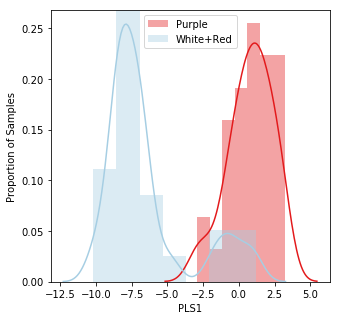

In [89]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(rad_balance[c1], 
             label='Purple', color=ch_color, bins=7, ax=ax)
sns.distplot(rad_balance[c2], 
             label='White+Red', color=cl_kl_color, bins=7, ax=ax)
ax.legend() 
ax.set_ylabel('Proportion of Samples')
ax.set_xlabel('PLS1')
plt.savefig('results/Purple_White+Red_histogram.pdf')

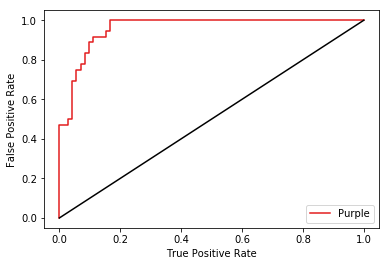

In [84]:
from sklearn.metrics import roc_curve
ch_fpr, ch_tpr, ch_thresholds = roc_curve(y_true=1-cats.astype(int), 
                                          y_score=rad_balance)

plt.plot(ch_tpr, ch_fpr, label='Purple', c=ch_color)
plt.plot(np.linspace(0, 1), np.linspace(0, 1), c='k')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig('purple_roc_curve.pdf')

In [85]:
from sklearn.metrics import auc
print('Purple AUC:\t\t', auc(ch_tpr, ch_fpr))

Purple AUC:		 0.959490740741


In [86]:
from scipy.stats import f_oneway
ch_f, ch_p = f_oneway(rad_balance.loc[c1],
                      rad_balance.loc[c2])
print('Purple \t -- F-statistic: %f \t p-value: \t %E' % (ch_f, ch_p))

Purple 	 -- F-statistic: 190.647188 	 p-value: 	 1.970325E-25


In [87]:
writer = pd.ExcelWriter('./results/cultivar_color_stats.xlsx')

stats = pd.Series([auc(ch_tpr, ch_fpr), cv['AUROC'].mean(), ch_f, ch_p],
                  index=['AUC', 'AUC_CV', 'F-statistic', 'p-value'])

x = cv['AUROC'].to_excel(writer, sheet_name='cv', index_label='folds')
stats.to_excel(writer, sheet_name='summary', header=False)
writer.save()

the code snippet below isn't applicable to metabolomics data- commented out

In [59]:
# parse out taxonomies such that each level of the taxonomy has its own column
# taxa_df = pd.DataFrame(taxa.Taxon.apply(lambda x: x.split(';')).values.tolist(),
#                        columns=['kingdom', 'phylum', 'class', 'order', 
#                                 'family', 'genus', 'species'],
#                        index=taxa.index)

In [60]:
# writer = pd.ExcelWriter('results/site_balance.xlsx')
# num_taxa = pd.merge(num, taxa_df, left_index=True, right_index=True)
# num_taxa.to_excel(writer, sheet_name='numerator')

# num_taxa['phylum'].value_counts().to_excel(writer, sheet_name='numerator_phyla')
# num_taxa['class'].value_counts().to_excel(writer, sheet_name='numerator_class')
# num_taxa['order'].value_counts().to_excel(writer, sheet_name='numerator_order')
# num_taxa['family'].value_counts().to_excel(writer, sheet_name='numerator_family')
# num_taxa['genus'].value_counts().to_excel(writer, sheet_name='numerator_genus')
# num_taxa['species'].value_counts().to_excel(writer, sheet_name='numerator_species')

# denom_taxa = pd.merge(denom, taxa_df, left_index=True, right_index=True)
# denom_taxa.to_excel(writer, sheet_name='denominator')

# denom_taxa['phylum'].value_counts().to_excel(writer, sheet_name='denominator_phyla')
# denom_taxa['class'].value_counts().to_excel(writer, sheet_name='denominator_class')
# denom_taxa['order'].value_counts().to_excel(writer, sheet_name='denominator_order')
# denom_taxa['family'].value_counts().to_excel(writer, sheet_name='denominator_family')
# denom_taxa['genus'].value_counts().to_excel(writer, sheet_name='denominator_genus')
# denom_taxa['species'].value_counts().to_excel(writer, sheet_name='denominator_species')

# writer.save()

In [61]:
t = np.log(table.apply(lambda x: (x+1 / x+1).sum(), axis=1))

In [62]:
def collapse_f(x):
    if x['cultivar_color'] == 'Purple':
        return 'Purple'
    else:
        return 'White+Red'
metadata['collapsed_treatment'] = metadata.apply(collapse_f, axis=1)

# Regression

not applicable to potato data as there aren't any continuos variables afaik

In [65]:
# from sklearn.mixture import GaussianMixture
# from scipy.stats import norm
# import numpy as np

# fig, ax = plt.subplots(figsize=(5, 5))
# rad_pls = PLSRegression(n_components=1)
# rad_pls.fit(X=ctable.values, Y=metadata.loc_rad_log.values)

# rad_spectrum = pd.DataFrame(rad_pls.x_weights_, index=ctable.columns, columns=['PLS1'])

# rad_mixture = GaussianMixture(n_components=3, 
#                               means_init=np.array([[-0.05], [0], [0.05]]), 
#                               random_state=0)
# rad_mixture.fit(X=rad_spectrum.values)

# rad_m = np.ravel(rad_mixture.means_)
# rad_s = np.ravel(np.sqrt(rad_mixture.covariances_)) 
# rad_w = np.ravel(rad_mixture.weights_)

# x = np.linspace(-0.1, 0.1, 100)
# sns.distplot(rad_spectrum, norm_hist=True, kde=False, ax=ax)
# ax.plot(x, rad_w[0]*norm.pdf(x, rad_m[0], rad_s[0]), '-r')
# ax.plot(x, rad_w[1]*norm.pdf(x, rad_m[1], rad_s[1]), '-g')
# ax.plot(x, rad_w[2]*norm.pdf(x, rad_m[2], rad_s[2]), '-b')

In [66]:
# from sklearn.model_selection import StratifiedKFold, KFold
# from scipy.stats import linregress

# def balance_regression(table, cats, num_folds, **init_kwds):
#     """
#     Builds a balance classifier. If categorical, it is assumed
#     that the classes are binary.
#     """
#     skf = KFold(n_splits=num_folds, shuffle=True)
#     cats = cats * -1 # wtf??
#     ctable = pd.DataFrame(clr(centralize(table+1)),
#                           index=table.index, columns=table.columns)

#     cv = pd.DataFrame(columns=['Q2'], index=np.arange(num_folds))
#     for i, (train, test) in enumerate(skf.split(ctable.values, cats.values)):

#         X_train, X_test = ctable.iloc[train], ctable.iloc[test]
#         Y_train, Y_test = cats.iloc[train], cats.iloc[test]
#         plsc = PLSRegression(n_components=1)
#         plsc.fit(X=X_train, Y=Y_train)
#         pls_df = pd.DataFrame(plsc.x_weights_, index=ctable.columns, columns=['PLS1'])

#         l, r = round_balance(pls_df, **init_kwds)
#         denom = pls_df.loc[pls_df.PLS1 < l]
#         num = pls_df.loc[pls_df.PLS1 > r]

#         idx = table.index[train]
#         pls_balance = (np.log(table.loc[idx, num.index] + 1).mean(axis=1) -
#                        np.log(table.loc[idx, denom.index] + 1).mean(axis=1))
#         b_, int_, _, _, _ = linregress(pls_balance, Y_train)

#         idx = table.index[test]
#         pls_balance = (np.log(table.loc[idx, num.index] + 1).mean(axis=1) -
#                        np.log(table.loc[idx, denom.index] + 1).mean(axis=1))
#         pred = pls_balance * b_ + int_
        
#         press = ((pred - Y_test)**2).sum()
#         tss = ((Y_test.mean() - Y_test)**2).sum()
#         Q2 = 1 - (press / tss)

#         cv.loc[i, 'Q2'] = Q2

#     # build model on entire dataset
#     plsc = PLSRegression(n_components=1)
#     plsc.fit(X=table.values, Y=cats.values)
#     pls_df = pd.DataFrame(plsc.x_weights_, index=ctable.columns, columns=['PLS1'])
#     l, r = round_balance(pls_df, **init_kwds)
#     denom = pls_df.loc[pls_df.PLS1 < l]
#     num = pls_df.loc[pls_df.PLS1 > r]
#     pls_balance = (np.log(table.loc[:, num.index] + 1).mean(axis=1) -
#                    np.log(table.loc[:, denom.index] + 1).mean(axis=1))

#     return num, denom, pls_balance, cv

In [67]:
# res = balance_regression(table, metadata.loc_rad_log, num_folds=4, 
#                          means_init=np.array([[-0.05], [0], [0.05]]) )
# num, denom, rad_balance, cv = res

In [68]:
# writer = pd.ExcelWriter('results/radiation_balance.xlsx')

# num_taxa = pd.merge(num, taxa_df, left_index=True, right_index=True)
# num_taxa.to_excel(writer, sheet_name='numerator')

# num_taxa['phylum'].value_counts().to_excel(writer, sheet_name='numerator_phyla')
# num_taxa['class'].value_counts().to_excel(writer, sheet_name='numerator_class')
# num_taxa['order'].value_counts().to_excel(writer, sheet_name='numerator_order')
# num_taxa['family'].value_counts().to_excel(writer, sheet_name='numerator_family')
# num_taxa['genus'].value_counts().to_excel(writer, sheet_name='numerator_genus')
# num_taxa['species'].value_counts().to_excel(writer, sheet_name='numerator_species')

# denom_taxa = pd.merge(denom, taxa_df, left_index=True, right_index=True)
# denom_taxa.to_excel(writer, sheet_name='denominator')

# denom_taxa['phylum'].value_counts().to_excel(writer, sheet_name='denominator_phyla')
# denom_taxa['class'].value_counts().to_excel(writer, sheet_name='denominator_class')
# denom_taxa['order'].value_counts().to_excel(writer, sheet_name='denominator_order')
# denom_taxa['family'].value_counts().to_excel(writer, sheet_name='denominator_family')
# denom_taxa['genus'].value_counts().to_excel(writer, sheet_name='denominator_genus')
# denom_taxa['species'].value_counts().to_excel(writer, sheet_name='denominator_species')


# writer.save()

In [69]:
# cv

The Q2 values are analogous to R2 - it essentially measures prediction accuracy.  The close it is to 1, the better.
Any Q2 values that are above zero are considered good.

In [70]:
# cv.mean()

In [71]:
# from scipy.stats import spearmanr, pearsonr
# r, p = spearmanr(rad_balance, metadata.loc_rad_log)
# print('CH \t -- R^2: %f \t p-value: \t %E' % (r, p))
# r, p = pearsonr(rad_balance, metadata.loc_rad_log)
# print('CH \t -- R^2: %f \t p-value: \t %E' % (r, p))

In [72]:
# writer = pd.ExcelWriter('results/radiation_stats.xlsx')

# stats = pd.Series([cv['Q2'].mean(), r, p],
#                   index=['Q2_CV', 'r', 'p'])
# cv['Q2'].to_excel(writer, sheet_name='cv', index_label='folds')
# stats.to_excel(writer, sheet_name='summary', header=False)
# writer.save()

In [73]:
# def rename_radiation(x):
#     if x['loc_rad_log'] > 0:
#         return 'high radiation'
#     else:
#         return 'low radiation'

# metadata['radiation_level'] = metadata.apply(rename_radiation, axis=1)
# num = num.sort_values(by='PLS1', ascending=False)
# denom = denom.sort_values(by='PLS1', ascending=True)

In [74]:
# num.head()

In [75]:
# denom.tail()

In [76]:
# num_taxa['family'].value_counts()

In [77]:
# denom_taxa['order'].value_counts()